In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/My Drive/brain_tumors.zip" -d "/content/dataset"


In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os

In [ ]:
# Function to prepend subdirectories to the image filenames in the dataframe
# Function to prepend subdirectories to the image filenames in the dataframe
def add_subdirectory_path(row):
    # Make sure these directory names match exactly with what's in your Drive
    subdirectory = "Brain_Tumor" if row['class'] == 'tumor' else "Healthy"
    return os.path.join(subdirectory, row['image'])

# Directories
current_directory = '/content/dataset/'  # Update this path
dataset_dir = os.path.join(current_directory, 'Brain Tumor Data Set')
# dataset_dir = '/content/dataset/Brain Tumor Data Set'  # Update this path

# Since os.path.abspath does not work in Colab, we set dataset_dir directly
# If the metadata.csv is inside the Brain Tumor Data Set folder, set it like this:
metadata_path = os.path.join(current_directory, 'metadata.csv')
metadata = pd.read_csv(metadata_path)

# Assuming add_subdirectory_path function is defined correctly above this
metadata['image'] = metadata.apply(add_subdirectory_path, axis=1)

# Simplify class labels to strings for binary classification
metadata['class'] = metadata['class'].replace({'tumor': 'tumor', 'healthy': 'healthy'})  # Keep the labels as strings

# Split the metadata into train, test, and validation sets
train_metadata, test_metadata = train_test_split(metadata, test_size=0.2, random_state=42)
train_metadata, valid_metadata = train_test_split(train_metadata, test_size=0.2, random_state=42)

# Image Data Generators
# Updated Image Data Generators with Data Augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # degrees
    width_shift_range=0.1,  # fraction of total width
    height_shift_range=0.1, # fraction of total height
    shear_range=0.2,        # shear intensity (shear angle in degrees)
    zoom_range=0.2,         # amount of zoom
    horizontal_flip=True,   # flipping the images horizontally
    fill_mode='nearest'     # strategy to fill newly created pixels
)

# The test_datagen and valid_datagen remain unchanged because we shouldn't augment our validation and test sets
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Now, recreate the data generators with the updated datagen
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_metadata,
    directory=dataset_dir,
    x_col='image',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_metadata,
    directory=dataset_dir,
    x_col='image',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_metadata,
    directory=dataset_dir,
    x_col='image',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


# Define the CNN model
from tensorflow.keras import regularizers

from tensorflow.keras.layers import BatchNormalization

model = models.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),  # Add batch normalization
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),  # Add batch normalization
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), strides=(2, 2), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),  # Add batch normalization
    layers.Activation('relu'),

    layers.Flatten(),
    layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    layers.Activation('swish'),

    layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1, activation='sigmoid')
])


model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Found 2944 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.
Found 736 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropou

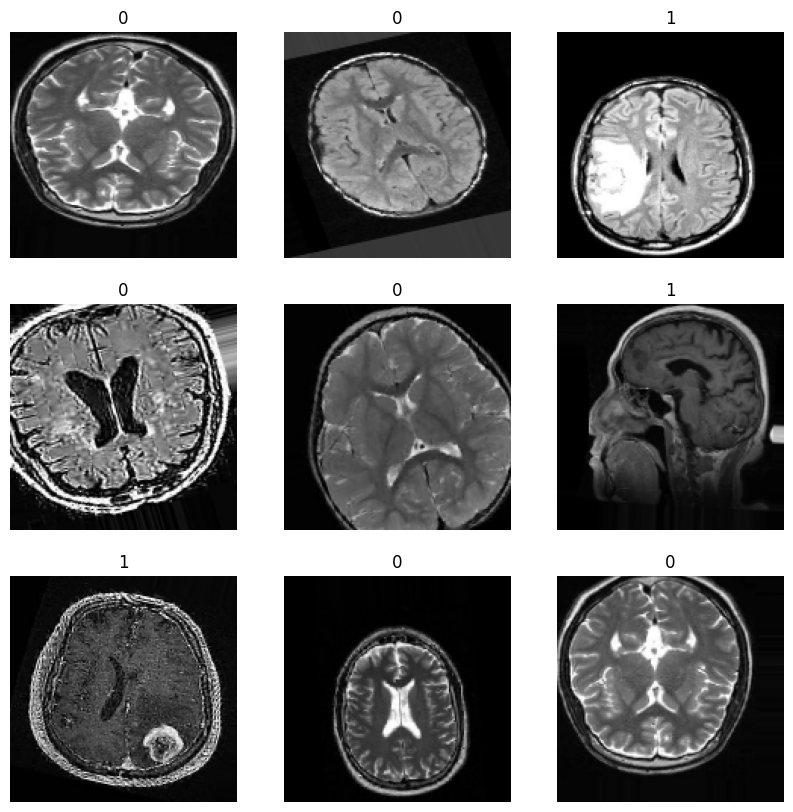

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images.tolist()[i]
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image)*255
        plt.imshow(f.astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

In [ ]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

# Add callbacks to the fit method
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_metadata) // 32,
    epochs=50,  # Increase epochs
    validation_data=valid_generator,
    validation_steps=len(valid_metadata) // 32,
    callbacks=[early_stopping, model_checkpoint]
)


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.2f}")

Epoch 1/50
92/92 [==============================] - 28s 203ms/step - loss: 1.1426 - accuracy: 0.7086 - val_loss: 1.4248 - val_accuracy: 0.5503
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 19s 201ms/step - loss: 0.9426 - accuracy: 0.7870 - val_loss: 1.2526 - val_accuracy: 0.5842
Epoch 3/50
92/92 [==============================] - 19s 201ms/step - loss: 0.8242 - accuracy: 0.8006 - val_loss: 0.9273 - val_accuracy: 0.6793
Epoch 4/50
92/92 [==============================] - 18s 198ms/step - loss: 0.7295 - accuracy: 0.8186 - val_loss: 1.2882 - val_accuracy: 0.5136
Epoch 5/50
92/92 [==============================] - 18s 200ms/step - loss: 0.6646 - accuracy: 0.8305 - val_loss: 0.6781 - val_accuracy: 0.8152
Epoch 6/50
92/92 [==============================] - 18s 201ms/step - loss: 0.6519 - accuracy: 0.8271 - val_loss: 0.6133 - val_accuracy: 0.8560
Epoch 7/50
92/92 [==============================] - 18s 200ms/step - loss: 0.6163 - accuracy: 0.8359 - val_loss: 0.5980 - val_accuracy: 0.8465
Epoch 8/50
92/92 [==============================] - 18s 198ms/step - loss: 0.6093 - accuracy: 0.8380 - val_loss: 0.7078 - val_accuracy: 0.7663
Epoch 9/50

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Function to prepend subdirectories to the image filenames in the dataframe
def add_subdirectory_path(row):
    subdirectory = "Brain_Tumor" if row['class'] == 'tumor' else "Healthy"
    return os.path.join(subdirectory, row['image'])

# Directories and data loading
current_directory = '/content/dataset/'
dataset_dir = os.path.join(current_directory, 'Brain Tumor Data Set')
metadata_path = os.path.join(current_directory, 'metadata.csv')
metadata = pd.read_csv(metadata_path)

# Apply the function to adjust the image paths
metadata['image'] = metadata.apply(add_subdirectory_path, axis=1)
metadata['class'] = metadata['class'].replace({'tumor': 'tumor', 'healthy': 'healthy'})

# Split the metadata into training, validation, and test sets
train_metadata, test_metadata = train_test_split(metadata, test_size=0.2, random_state=42)
train_metadata, valid_metadata = train_test_split(train_metadata, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_metadata,
    directory=dataset_dir,
    x_col='image',
    y_col='class',
    target_size=(299, 299),  # Match InceptionV3's expected input
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_metadata,
    directory=dataset_dir,
    x_col='image',
    y_col='class',
    target_size=(299, 299),  # Match InceptionV3's expected input
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_metadata,
    directory=dataset_dir,
    x_col='image',
    y_col='class',
    target_size=(299, 299),  # Match InceptionV3's expected input
    batch_size=32,
    class_mode='binary'
)

# Load InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze the base model initially

# Add custom layers on top for our specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Initial training
initial_epochs = 10
history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=valid_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_model_pre_fine_tuning.h5', save_best_only=True)
    ]
)

# Unfreeze some of the top layers of the model for fine-tuning
base_model.trainable = True
fine_tune_at = 249  # This is the layer from which we want to fine-tune

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tuning
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=valid_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_model_post_fine_tuning.h5', save_best_only=True)
    ]
)

# Evaluate the fine-tuned model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy after fine-tuning: {test_accuracy:.2f}")


Found 2760 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.
87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 0.4536 - accuracy: 0.7783

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 65s 675ms/step - loss: 0.4536 - accuracy: 0.7783 - val_loss: 0.3121 - val_accuracy: 0.8772
Epoch 2/10
87/87 [==============================] - 57s 651ms/step - loss: 0.3076 - accuracy: 0.8739 - val_loss: 0.2602 - val_accuracy: 0.9065
Epoch 3/10
87/87 [==============================] - 56s 646ms/step - loss: 0.2638 - accuracy: 0.8920 - val_loss: 0.2407 - val_accuracy: 0.9000
Epoch 4/10
87/87 [==============================] - 57s 657ms/step - loss: 0.2271 - accuracy: 0.9098 - val_loss: 0.2163 - val_accuracy: 0.9098
Epoch 5/10
87/87 [==============================] - 59s 683ms/step - loss: 0.2088 - accuracy: 0.9159 - val_loss: 0.1996 - val_accuracy: 0.9261
Epoch 6/10
87/87 [==============================] - 59s 682ms/step - loss: 0.2013 - accuracy: 0.9250 - val_loss: 0.1910 - val_accuracy: 0.9272
Epoch 7/10
87/87 [==============================] - 56s 641ms/step - loss: 0.1930 - accuracy: 0.9264 - val_loss: 0.2309 - val_accuracy: 0.8978
Epoch 8/10

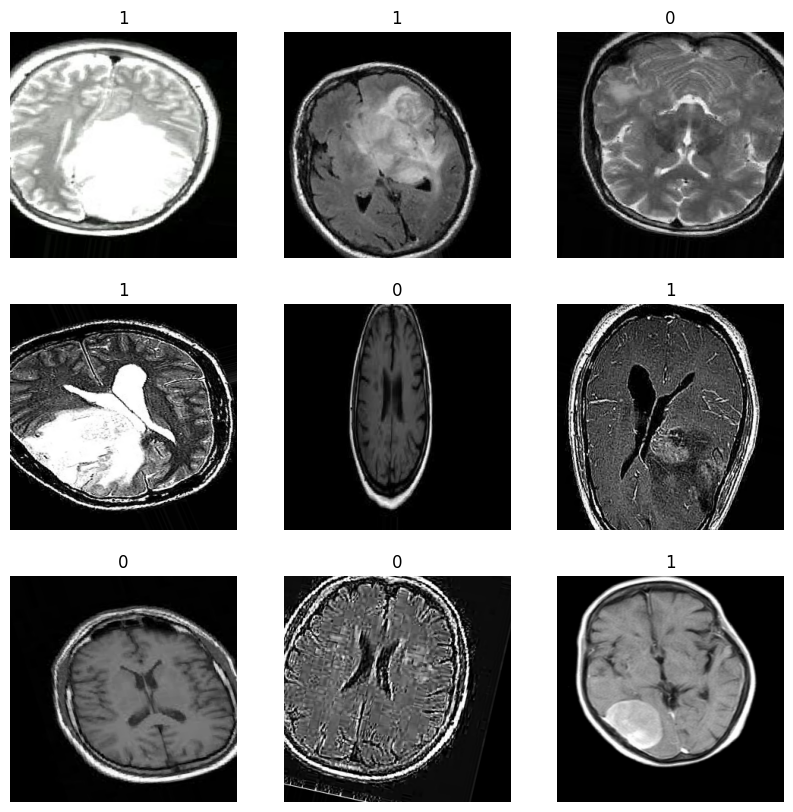

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images.tolist()[i]
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image)*255
        plt.imshow(f.astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

In [ ]:
import numpy as np

# Assuming test_generator does not use shuffle=True for accurate label correspondence.

predictions = model.predict(test_generator)

# Convert probabilities to binary predictions assuming 0.5 as threshold
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)


29/29 [==============================] - 3s 91ms/step


In [ ]:
true_classes = test_generator.classes
incorrect_indices = np.where(predicted_classes != true_classes)[0]
num_incorrect = len(incorrect_indices)

In [ ]:
print(f"Number of misclassified images: {num_incorrect}")


Number of misclassified images: 457


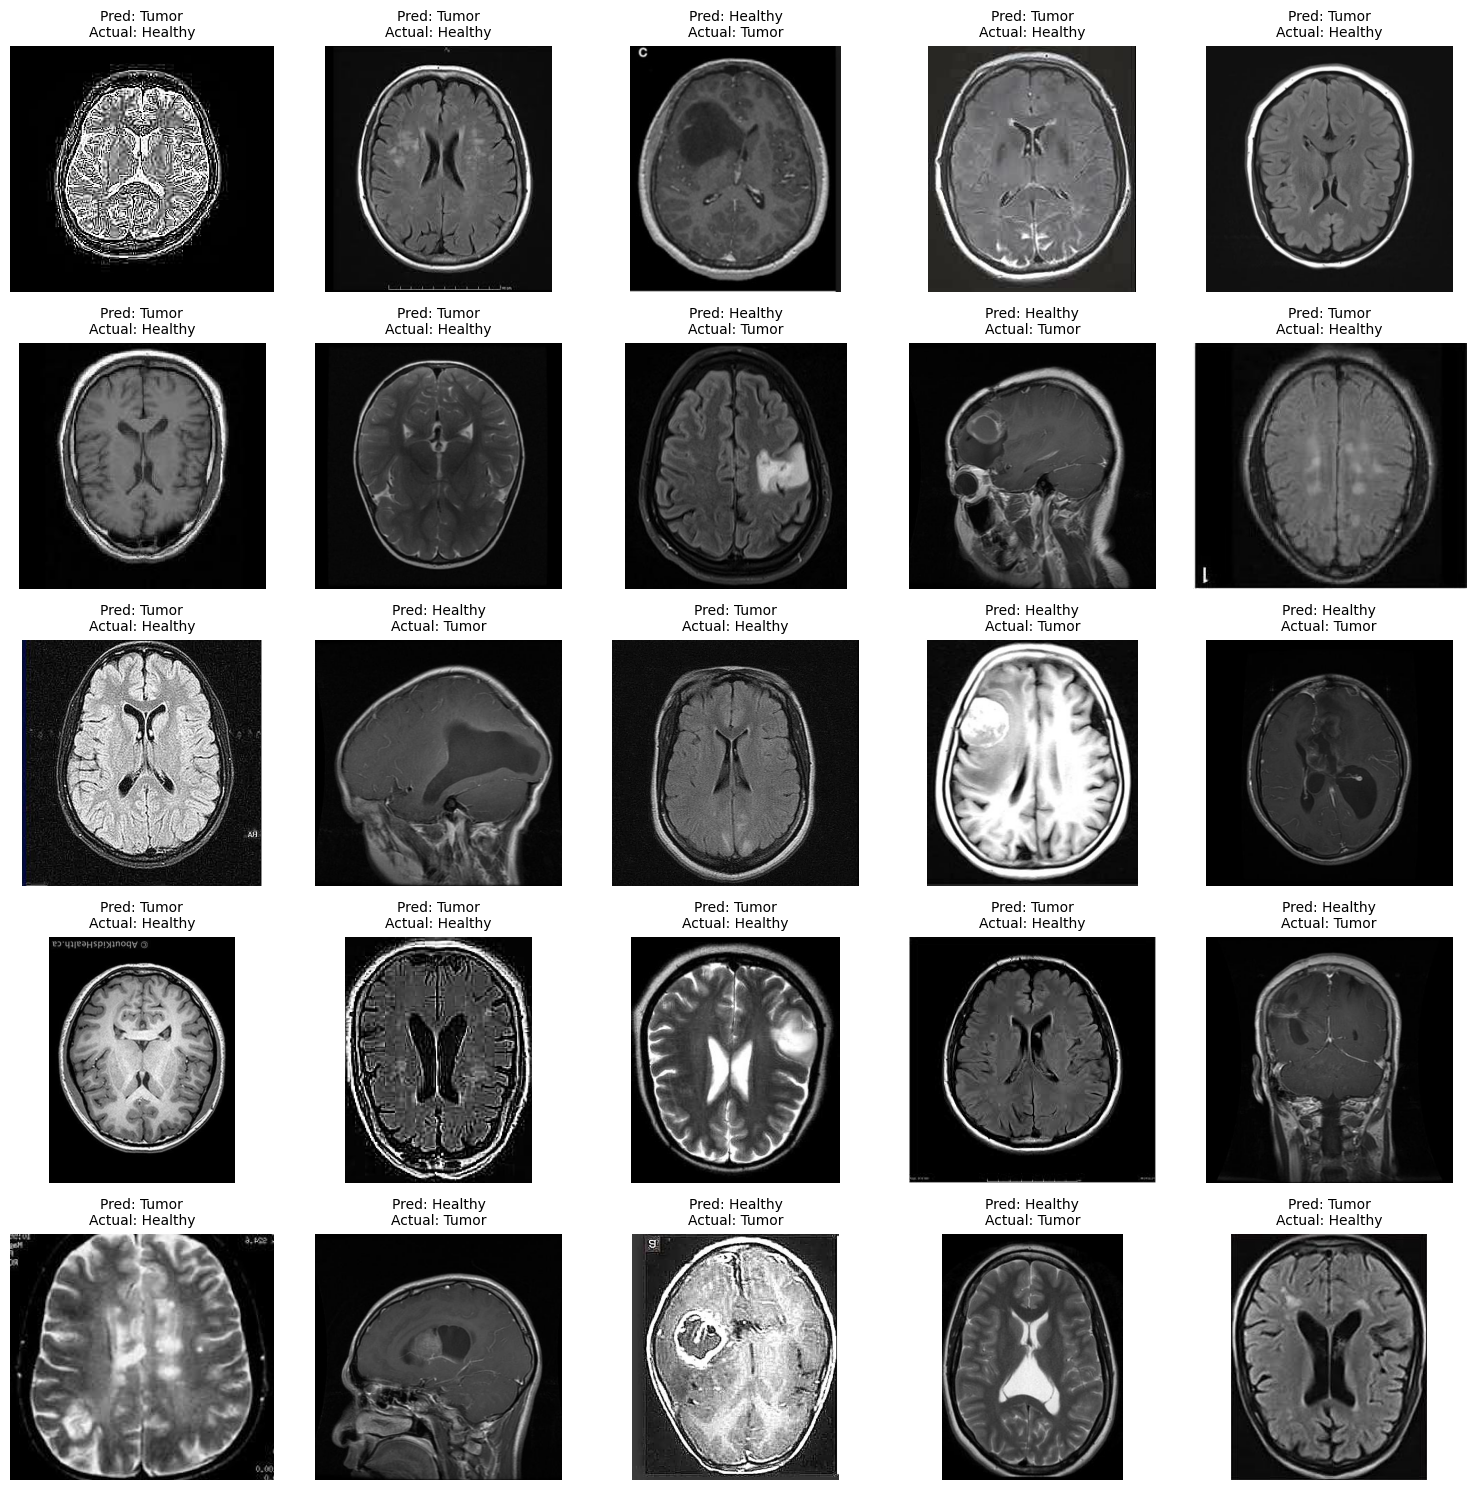

In [ ]:
num_incorrect = len(incorrect_indices)
# Display only up to 25 misclassified images to avoid overloading the display
max_display = min(25, num_incorrect)
grid_size = int(np.ceil(np.sqrt(max_display)))

plt.figure(figsize=(grid_size * 3, grid_size * 3))

for index in range(max_display):
    incorrect_index = incorrect_indices[index]
    plt.subplot(grid_size, grid_size, index + 1)
    incorrect_path = test_generator.filepaths[incorrect_index]
    img = plt.imread(os.path.join(dataset_dir, incorrect_path))

    plt.imshow(img)
    plt.title(f"Pred: {'Tumor' if predicted_classes[incorrect_index] == 1 else 'Healthy'}\nActual: {'Tumor' if true_classes[incorrect_index] == 1 else 'Healthy'}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
